In this notebook we build the final data to be analysed. 

**R1 version: We take also the intracraneal volume and age, sex, and education level for confounding**

In [2]:
import numpy as np
import pandas as pd
from os.path import join as opj
from scipy.io import loadmat
import h5py

In [3]:
#data_dir = "/media/javi/ExtraDrive2/local_fingerprint_varoquox"

In [4]:
f = h5py.File(opj("../data", "data_response_variables.hdf5"), "r")
YY_domain_cognition = f['Y_cognition'][:]
subjects = f['subjects'][:]
f.close()

In [101]:
unrestricted_dat = pd.merge(pd.DataFrame({'Subject': subjects}),
                            pd.read_excel("../data/unrestricted_jraserod_8_16_2019_12_4_12.xlsx"),
                            on='Subject')  

restricted_dat = pd.read_csv("../data/RESTRICTED_frankyeh_8_2_2017_12_54_49.csv")
restricted_dat = pd.merge(pd.DataFrame({'Subject': subjects}), restricted_dat, on='Subject')

In [5]:
connectome_features, surface_features, thickness_features, sub_vols_features = [], [], [], []

for sub_id in subjects:
    output_connectome = opj(data_dir, "final", "functional", "sub-" + str(sub_id), "connectome.txt")
    connectome = np.loadtxt(output_connectome)
    connectome_features.append(connectome[np.triu_indices_from(connectome, k=1)])
    
    output_surface = opj(data_dir, "final", "structural", "sub-" + str(sub_id), "surface.txt")
    surface_features.append(np.loadtxt(output_surface))
    
    output_thickness = opj(data_dir, "final", "structural", "sub-" + str(sub_id), "thickness.txt")
    thickness_features.append(np.loadtxt(output_thickness))
    
    output_sub_vols = opj(data_dir, "final", "structural", "sub-" + str(sub_id), "sub_volumes.txt")
    sub_vols_df = pd.read_csv(output_sub_vols, sep="\t")
    # we are discarding the ICV, as it will correspond to a neuroimaging confounder
    sub_vols_features.append(sub_vols_df[sub_vols_df.iloc[:, 0] != "EstimatedTotalIntraCranialVol"].iloc[:,1].values)
    
connectome_features = np.asarray(connectome_features)
surface_features = np.asarray(surface_features)
thickness_features = np.asarray(thickness_features)
sub_vols_features = np.asarray(sub_vols_features)

In [6]:
# ICV variable, which will correspond to our neuroimaging confounder
icv_var = unrestricted_dat.FS_IntraCranial_Vol.values

In [7]:
# Check that indeed it's the same data as the one we had in the freesurfer donwloaded files

icv_downloaded = []
for sub_id in subjects:
    output_sub_vols = opj(data_dir, "final", "structural", "sub-" + str(sub_id), "sub_volumes.txt")
    sub_vols_df = pd.read_csv(output_sub_vols, sep="\t")
    # we are discarding the ICV, as it will correspond to a neuroimaging confounder
    icv_downloaded.append(sub_vols_df[sub_vols_df.iloc[:, 0] == "EstimatedTotalIntraCranialVol"].iloc[:,1])

icv_downloaded = np.squeeze(np.asarray(icv_downloaded))

In [8]:
np.corrcoef(icv_var, icv_downloaded)

array([[1.        , 0.99999998],
       [0.99999998, 1.        ]])

In [9]:
# Here we load the local connectome data, previously downloaded from  
# http://dsi-studio.labsolver.org/download-images/local-connectome-fingerprints-of-hcp-1062-subjects-for-neofac-prediction
loc_conn_names = loadmat(opj(data_dir,"HCP1062_NEOFAC_fp.mat"), 
                         squeeze_me = True, variable_names = "names")['names']
loc_conn_dat = loadmat(opj(data_dir,"HCP1062_NEOFAC_fp.mat"), 
                       squeeze_me = True, variable_names = "subjects")['subjects']

In [10]:
loc_conn_features = []

for subj in subjects:

    loc_conn_features.append(loc_conn_dat[loc_conn_names == subj].flatten())

loc_conn_features = np.array(loc_conn_features)

In [11]:
# Here are the "mediating" confounders, which consist of age, sex and years of education
# let's form then our confounding channel, with ICV, gender, sex and education
confounder_features = np.column_stack((pd.get_dummies(unrestricted_dat.Gender, drop_first=True).values,
                                      restricted_dat.Age_in_Yrs.values,
                                      restricted_dat.SSAGA_Educ.values))

In [12]:
# There's one subject with no education info, so we will discard that subject
mask = ~np.any(np.isnan(confounder_features), 1)
print("subjects with completed confound data = %i" % sum(mask))

subjects with completed confound data = 1028


we mask the data dropping this case then...

In [13]:
# Independent neurodata
connectome_features = connectome_features[mask]
surface_features = surface_features[mask]
thickness_features = thickness_features[mask]
sub_vols_features = sub_vols_features[mask]
loc_conn_features = loc_conn_features[mask]
# Dependent or response data
YY_domain_cognition = YY_domain_cognition[mask]

# Confounders
icv_var = icv_var[mask]
confounder_features = confounder_features[mask]

# Subjects
subjects = subjects[mask]

In [14]:
print("The shape of connectome features matrix is ", connectome_features.shape)
print("The shape of surface features matrix is ", surface_features.shape)
print("The shape of thickness features matrix is ", thickness_features.shape)
print("The shape of subcortial volumes features matrix is ", sub_vols_features.shape)
print("The shape of local connectome features matrix is ", loc_conn_features.shape)
print("The shape of target matrix for predefined domain scores is ", YY_domain_cognition.shape)
print("The shape of mediating confounders matrix is ", confounder_features.shape)
print("The shape of neuroimaging confounders matrix is ", icv_var.shape)

The shape of connectome features matrix is  (1028, 257403)
The shape of surface features matrix is  (1028, 360)
The shape of thickness features matrix is  (1028, 360)
The shape of subcortial volumes features matrix is  (1028, 65)
The shape of local connectome features matrix is  (1028, 128894)
The shape of target matrix for predefined domain scores is  (1028, 7)
The shape of mediating confounders matrix is  (1028, 3)
The shape of neuroimaging confounders matrix is  (1028,)


In [15]:
subjects.shape

(1028,)

In [22]:
#Save these to disk

f =  h5py.File(opj("../data", "final_data_R1.hdf5"), "w")

f.create_dataset("connectome_features", data=connectome_features)
f.create_dataset("surface_features", data=surface_features)
f.create_dataset("thickness_features", data=thickness_features)
f.create_dataset("sub_vols_features", data=sub_vols_features)
f.create_dataset("loc_conn_features", data=loc_conn_features)
f.create_dataset("YY_domain_cognition", data=YY_domain_cognition)
f.create_dataset("confounder_features", data=confounder_features)
f.create_dataset("intracv_feature", data=icv_var)
f.create_dataset("subjects", data=subjects)

f.close()

# Reviewer 1 request: Show the distribution of the response variables

In [5]:
with h5py.File(opj("../data", "final_data_R1.hdf5"), "r") as f:
    YY_domain_cognition = f['YY_domain_cognition'][:]

In [14]:
import matplotlib.pylab as plt
import ptitprince as pt
import seaborn as sns

In [7]:
score_names = ['CogTotalComp_Unadj', 
               'CogFluidComp_Unadj', 
               'CogCrystalComp_Unadj', 
               'SCPT_SEN', 
               'DDisc_AUC_200', 
               'IWRD_TOT', 
               'VSPLOT_TC']

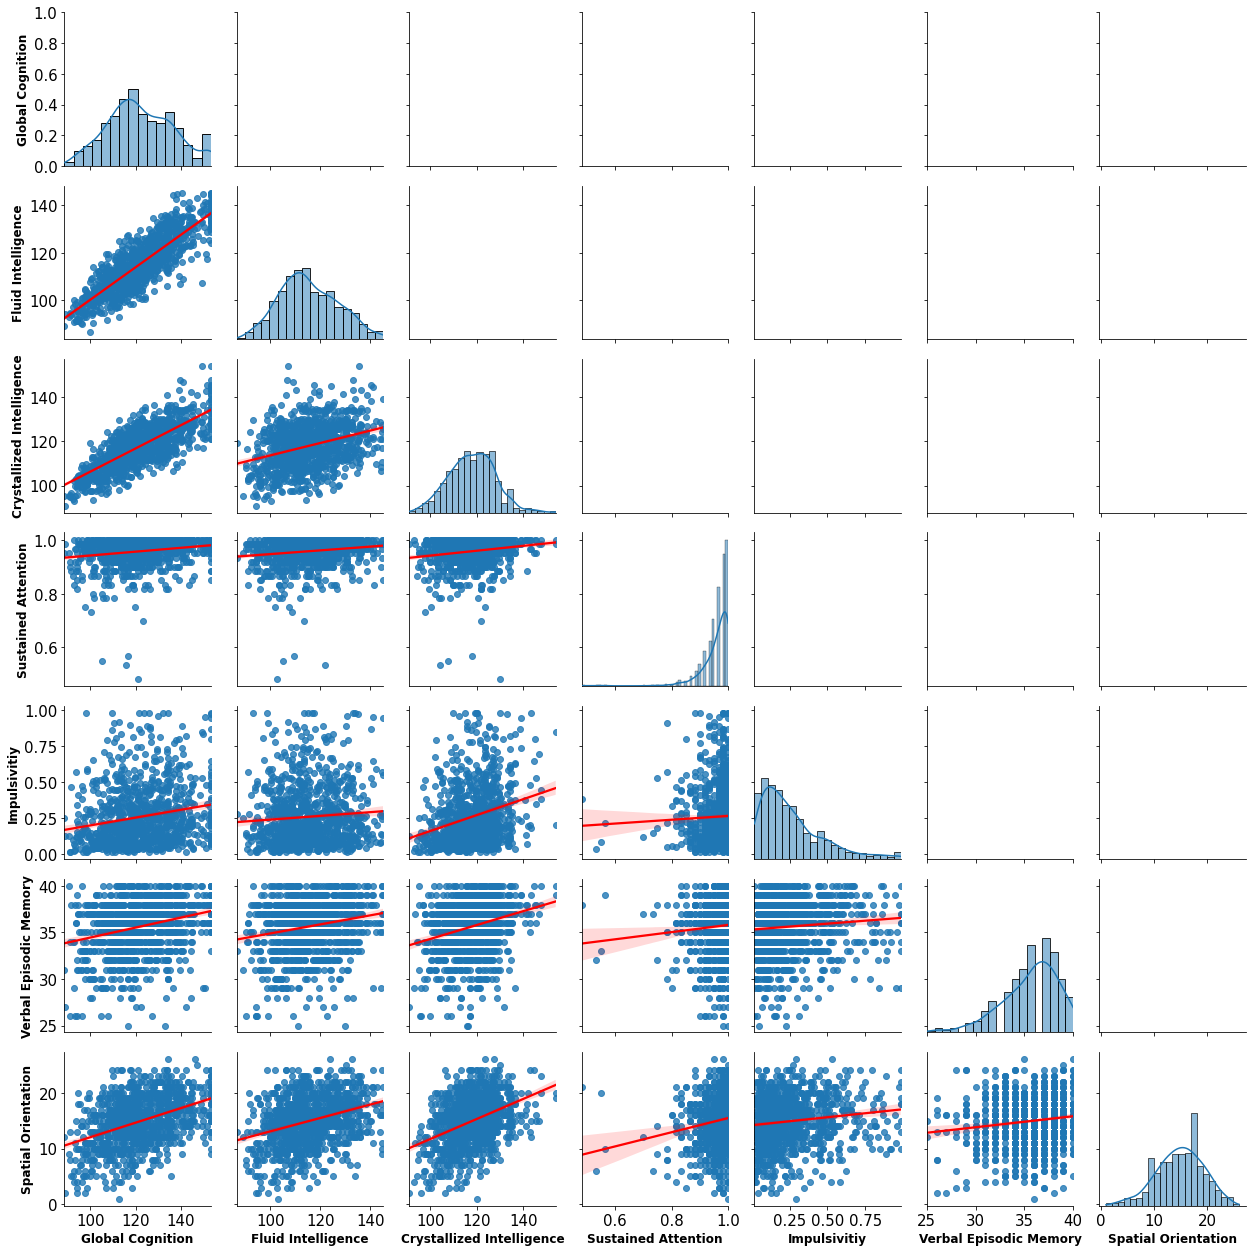

In [82]:
g = sns.PairGrid(pd.DataFrame(YY_domain_cognition, 
                              columns = ["Global Cognition",
                                         "Fluid Intelligence",
                                         "Crystallized Intelligence",
                                         "Sustained Attention",
                                         "Impulsivitiy",
                                         "Verbal Episodic Memory",
                                         "Spatial Orientation"]))
g.map_lower(sns.regplot, line_kws ={'color':'red'})
g.map_diag(sns.histplot, kde=True)

for ax in g.axes[6,:]:
    ax.xaxis.set_tick_params(labelsize=15)
    ax.xaxis.label.set_size(12)
    ax.xaxis.label.set_weight('bold')
    
for ax in g.axes[:,0]:
    ax.yaxis.set_tick_params(labelsize=15)
    ax.yaxis.label.set_size(12)
    ax.yaxis.label.set_weight('bold')

plt.tight_layout()
plt.savefig("../plots/R1/response_pairplot.png", dpi=300)

In [88]:
# These pearson coefficients to later insert them in the above plot in inkscape
np.round(np.corrcoef(YY_domain_cognition.T), 3)

array([[1.   , 0.849, 0.769, 0.202, 0.191, 0.268, 0.426],
       [0.849, 1.   , 0.33 , 0.157, 0.073, 0.195, 0.314],
       [0.769, 0.33 , 1.   , 0.175, 0.265, 0.255, 0.399],
       [0.202, 0.157, 0.175, 1.   , 0.033, 0.068, 0.147],
       [0.191, 0.073, 0.265, 0.033, 1.   , 0.09 , 0.132],
       [0.268, 0.195, 0.255, 0.068, 0.09 , 1.   , 0.129],
       [0.426, 0.314, 0.399, 0.147, 0.132, 0.129, 1.   ]])